In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from scipy.special import erf
from lifelines import CoxTimeVaryingFitter
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_survivor,
    simulate_infections_discrete,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide,
    get_constant_foi,
    get_constant_foi_survivor
)

from multipathogen_sero.config import PROJ_ROOT
# # Prepend to PATH (Windows uses ; as separator)
# current_path = os.environ.get('PATH', '')
# new_path = ';'.join(CMDSTAN_PATHS) + ';' + current_path
# os.environ['PATH'] = new_path


2025-08-07 19:04:25.289 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


# Simulation

In [173]:
n_people = 1000 #number of individuals n
np.random.seed(42)  # For reproducibility
t_max=100
birth_times = np.random.uniform(0, t_max, size=n_people)  # Random birth times for individuals
n_pathogens=5 #number of pathogens K

pathogen_names = [f'Pathogen {i+1}' for i in range(n_pathogens)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]

baseline_hazards = [1.0 for k in range(n_pathogens)]  # Example baseline hazards
foi_list = [
    get_constant_foi(a=baseline_hazards[k]) for k in range(n_pathogens)
]
survivor_list = [
    get_constant_foi_survivor(a=baseline_hazards[k]) for k in range(n_pathogens)
]

Text(0.5, 0, 'Time')

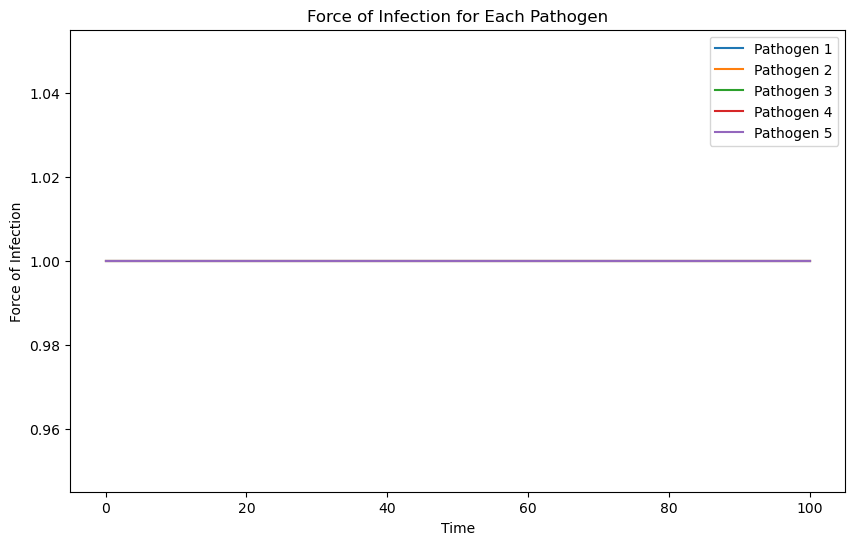

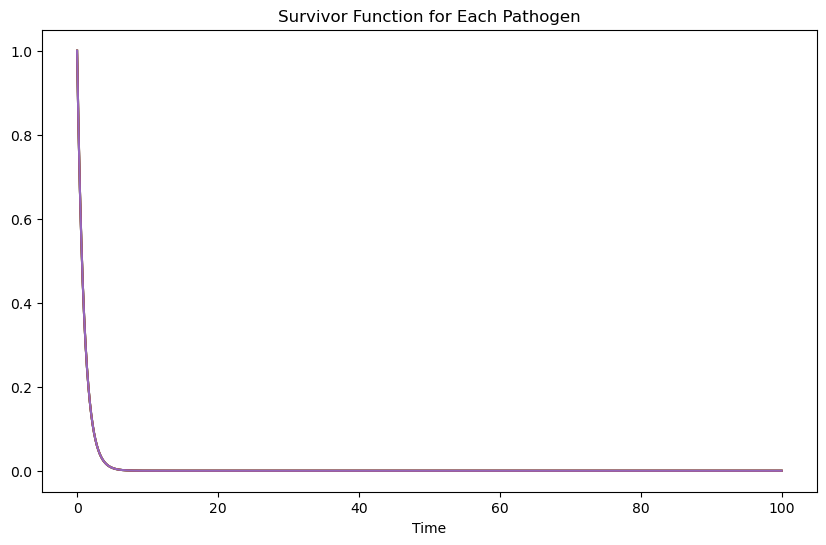

In [174]:
#plot fois
t = np.linspace(0, t_max, 1000)
plt.figure(figsize=(10, 6)) 
for k, foi in enumerate(foi_list):
    plt.plot(t, foi(t), label=pathogen_names[k])
plt.title('Force of Infection for Each Pathogen')
plt.xlabel('Time')
plt.ylabel('Force of Infection')
plt.legend()

#plot survivors
plt.figure(figsize=(10, 6))
for k, survivor in enumerate(survivor_list):
    plt.plot(t, survivor(t), label=pathogen_names[k])
plt.title('Survivor Function for Each Pathogen')
plt.xlabel('Time')

Component 1: [0, 1, 2]
Component 2: [3]
Component 3: [4]


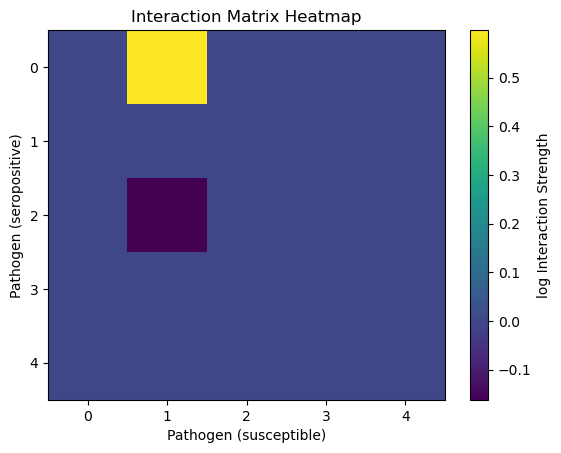

In [175]:
# Interaction matrix

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# spike and slab on each coefficient of the interaction matrix
np.random.seed(42)  # For reproducibility
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
interaction_mat = np.exp(
    np.random.normal(0, 1, size=(n_pathogens, n_pathogens)) * interaction_indicator
)
#plot the interaction matrix as a heatmap
plt.imshow(np.log(interaction_mat), cmap='viridis', aspect='auto')
plt.ylabel('Pathogen (seropositive)')
plt.xlabel('Pathogen (susceptible)')
plt.xticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.yticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.colorbar(label='log Interaction Strength')
plt.title('Interaction Matrix Heatmap')

# Convert interaction_indicator to a sparse matrix
adj_matrix = csr_matrix(interaction_indicator)

# Find weakly connected components (ignoring direction)
n_components, labels = connected_components(csgraph=adj_matrix, directed=True, connection='weak')

# Group node indices by component
components = [np.where(labels == i)[0] for i in range(n_components)]

for i, comp in enumerate(components):
    print(f"Component {i+1}: {comp.tolist()}")

In [176]:
start = time.time()
simulate_infections_df = simulate_infections(n_people, n_pathogens, foi_list, interaction_mat, t_max=t_max, birth_times=birth_times, random_seed=42)
print(f"simulate_infections took {time.time() - start:.3f} seconds")


simulate_infections took 0.308 seconds


# Bayesian Cox Regression

In [28]:
#########################
k_infector = 1       # Infecting pathogen to analyze
n_people_subsample = min(100, n_people)  # Subsample size for analysis
#########################


regression_df_for_pathogen_k = simulation_to_regression_df(
    simulate_infections_df,
    k_infector=k_infector,  # Set to None to include all pathogens, or specify a specific pathogen index
    t_max=t_max
)
regression_df_for_pathogen_k_subsampled = regression_df_for_pathogen_k[regression_df_for_pathogen_k["individual"]<=n_people_subsample]

In [158]:
stan_data = {
    "N": n_people_subsample, # Number of individuals
    "P": n_pathogens - 1, # Number of covariates
    "n_rows": len(regression_df_for_pathogen_k_subsampled), # Number of observation rows
    "T_L": regression_df_for_pathogen_k_subsampled["start_time"].values,
    "T_R": regression_df_for_pathogen_k_subsampled["stop_time"].values,
    "event": regression_df_for_pathogen_k_subsampled["event"].values,
    "person_id": regression_df_for_pathogen_k_subsampled["individual"].values,
    "X": regression_df_for_pathogen_k_subsampled.filter(like='serostatus_').values, # get the data for columns starting with serostatus_,
    "beta_prior_setting": 2, # 0 for no prior, 1 for Laplace prior, 2 for spike and slab prior
    "laplace_scale": 1.0,  # scale for Laplace prior when beta_prior_setting == 1
    "slab_scale": 1.0,  # Scale for the slab in spike and slab prior
    "spike_scale": 0.05,  # Scale for the spike in spike and slab prior
    "pi": 0.1 # Inclusion probability for the spike and slab prior
}

In [30]:
model = CmdStanModel(stan_file= PROJ_ROOT / "multipathogen_sero" / "infection_histories.stan")

fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=3000,
    iter_warmup=500,
    parallel_chains=4,
    seed=123
)

19:20:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:56 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

                     Mean      MCSE    StdDev       MAD        5%       50%  \
lp__            -4.431660  0.084534  1.822960  0.922066 -8.769930 -3.759710   
baseline_hazard  0.021103  0.000357  0.021347  0.015070  0.000993  0.014316   
beta_raw[1]     -0.003703  0.009240  0.318928  0.055382 -0.125300 -0.001313   
beta[1]         -0.003703  0.009240  0.318928  0.055382 -0.125300 -0.001313   
log_lik[1]      -5.357720  0.017178  0.822538  0.389190 -7.064000 -5.039510   
log_lik[2]      -0.104006  0.001759  0.105208  0.074272 -0.315259 -0.070555   

         

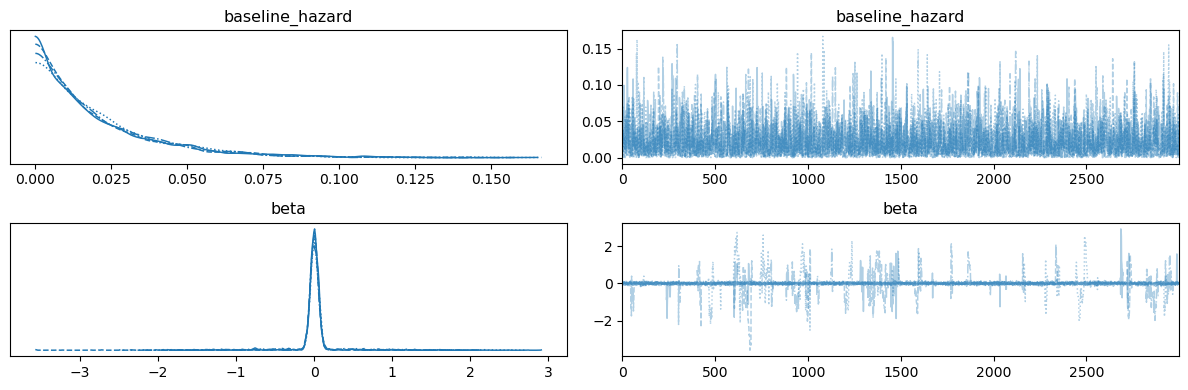

In [31]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazard", "beta"])
plt.tight_layout()
plt.show()

True baseline hazard: 0.01


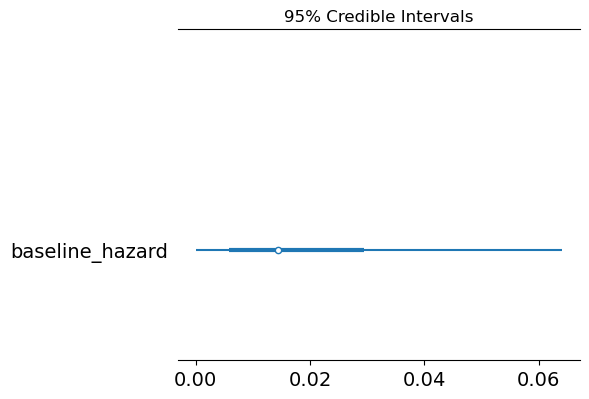

True beta coefficients: [0.]


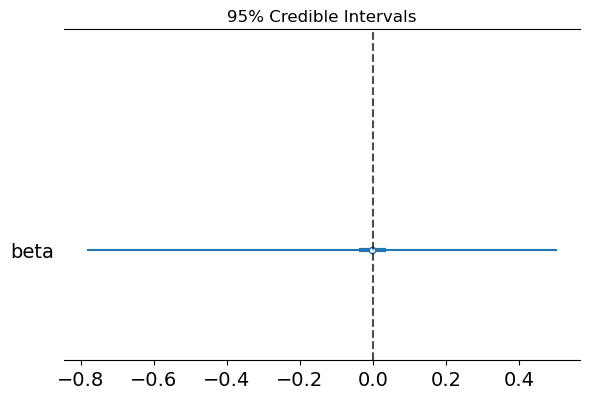

In [32]:
print(f"True baseline hazard: {baseline_hazards[k_infector-1]}")
az.plot_forest(idata, var_names=["baseline_hazard"], 
               hdi_prob=0.95, combined=True)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {np.log(np.concatenate([interaction_mat[:k_infector-1, k_infector-1],interaction_mat[k_infector:, k_infector-1]]))}")

ax = az.plot_forest(idata, var_names=["beta"], 
                    hdi_prob=0.95, combined=True)
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

In [33]:
idata = az.from_cmdstanpy(posterior=fit)
# Now you can calculate WAIC and LOO
waic = az.waic(idata)
loo = az.loo(idata)

print(waic)
print(loo)

Computed from 12000 posterior samples and 2 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    -5.94     4.05
p_waic        0.69        -

There has been a warning during the calculation. Please check the results.
Computed from 12000 posterior samples and 2 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -6.32     4.32
p_loo        1.07        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        1   50.0%
   (0.70, 1]   (bad)         1   50.0%
   (1, Inf)   (very bad)    0    0.0%



/home/ayan/anaconda3/envs/multipathogen-sero/lib/python3.11/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/ayan/anaconda3/envs/multipathogen-sero/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


# serological data

In [177]:
survey_times = {i+1: np.insert(np.arange(np.floor(birth_times[i]+1), t_max+1), 0, birth_times[i]) for i in range(n_people)}

def get_survey_bounds(row):
    times = survey_times[row["individual"]]
    i = np.searchsorted(times, row["time"], side="left")
    if i == len(times):
        raise NotImplementedError(f"No next survey time ≥ {row['time']} for individual {row['individual']}")
    if i == 0:
        raise NotImplementedError(f"No last survey time < {row['time']} for individual {row['individual']}")
    next_time = times[i]
    last_time = times[i - 1]
    return pd.Series({"last_survey_time": last_time, "next_survey_time": next_time})

# infections
infection_intervals = simulate_infections_df.query("event == 'seroconversion'").copy()
infection_intervals["pathogen"] = infection_intervals["pathogen"].astype(int)
infection_intervals[["last_survey_time", "next_survey_time"]] = infection_intervals.apply(get_survey_bounds, axis=1)
last_survey_times = infection_intervals["last_survey_time"].values
next_survey_times = infection_intervals["next_survey_time"].values
infection_person_ids = infection_intervals["individual"].values
infection_pathogen_ids = infection_intervals["pathogen"].values

# lookup
gets_infected = np.zeros((n_people, n_pathogens), dtype=bool)
lookup_indices = np.zeros((n_people, n_pathogens), dtype=int)
for counter, row in enumerate(infection_intervals.itertuples()):
    gets_infected[row.individual - 1, row.pathogen - 1] = True
    lookup_indices[row.individual - 1, row.pathogen - 1] = counter+1 #1-indexed
num_infections = gets_infected.sum()

# noninfections
num_noninfections = n_people * n_pathogens - num_infections
indices = np.argwhere(gets_infected == 0)
lookup_indices[gets_infected == 0] = np.arange(1, num_noninfections + 1) #1-indexed
noninfection_person_ids = indices[:, 0] + 1  # Convert to 1-based indexing
noninfection_pathogen_ids = indices[:, 1] + 1  # Convert to 1-based indexing
censoring_times = np.array([survey_times[i][-1] for i in noninfection_person_ids])


In [194]:
"""
data {
    int<lower=1> N;                         // Number of individuals
    array[N] real birth_times;               // Birth time for each individual
    int<lower=1> K;                         // Number of pathogens
    array[N,K] int<lower=0, upper=1> gets_infected; // 0 = always negative, 1 = seroconverter
    int<lower=0> num_infections; // Number of infection times (seroconversions)
    int<lower=0> num_noninfections; // Number of uninfected individuals (seronegative)
    array[N,K] int<lower=1, upper=N*K> lookup_indices; // Index to look up individual, pathogen infection times in their respective (1-indexed) arrays
    array[num_infections] real lower_bound_times; // Lower bound of seroconversion time
    array[num_infections] real upper_bound_times; // Upper bound of seroconversion time
    array[num_infections] int<lower=1, upper=N> infection_person_ids; // Individual ID for each seroconversion (should be 1-indexed)
    array[num_infections] int<lower=1, upper=K> infection_pathogen_ids; // Pathogen ID for each seroconversion (should be 1-indexed)
    array[num_noninfections] real censoring_times; // Lower bound of seroconversion time
    array[num_noninfections] int<lower=1, upper=N> noninfection_person_ids; // Individual ID for each seronegative individual (should be 1-indexed)
    array[num_noninfections] int<lower=1, upper=K> noninfection_pathogen_ids; // Pathogen ID for each seronegative individual (should be 1-indexed)
    real <lower=0> time_to_immunity; // timescale for immunity to kick in
                                     // not scientific, just to make the likelihood continuous wrt latent infection times 
    real <lower=0> beta_scale; // scale for Laplace prior on log hazard ratios
    real <lower=0> relative_tolerance; // Relative tolerance for numerical integration (the default caused exceptions)
}
"""
# TODO: write tests
stan_data = {
    "N": n_people,
    "birth_times": birth_times,
    "K": n_pathogens,
    "gets_infected": gets_infected,
    "num_infections": num_infections,
    "num_noninfections": num_noninfections,
    "lookup_indices": lookup_indices,
    "lower_bound_times": last_survey_times,
    "upper_bound_times": next_survey_times,
    "infection_person_ids": infection_person_ids,
    "infection_pathogen_ids": infection_pathogen_ids,
    "censoring_times": censoring_times,
    "noninfection_person_ids": noninfection_person_ids,
    "noninfection_pathogen_ids": noninfection_pathogen_ids,
    "time_to_immunity": 0.05,  # timescale for immunity to kick in
    "beta_scale": 1.0,  # scale for Laplace prior on log hazard ratios
    "relative_tolerance": 1e-1  # Relative tolerance for numerical integration
}

print(birth_times[0])
print(gets_infected[0])
print(lookup_indices[0])
print(last_survey_times[lookup_indices[0][gets_infected[0]]-1])
print(next_survey_times[lookup_indices[0][gets_infected[0]]-1])
print(infection_person_ids[lookup_indices[0][gets_infected[0]]-1])
print(infection_pathogen_ids[lookup_indices[0][gets_infected[0]]-1])
print(censoring_times[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_person_ids[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_pathogen_ids[lookup_indices[0][~gets_infected[0]]-1])

37.454011884736246
[ True  True  True  True  True]
[2 3 4 5 1]
[37.45401188 37.45401188 38.         39.         37.45401188]
[38. 38. 39. 40. 38.]
[1 1 1 1 1]
[1 2 3 4 5]
[]
[]
[]


In [185]:
model = CmdStanModel(stan_file= PROJ_ROOT / "multipathogen_sero" / "multiplex_serology.stan")


02:42:38 - cmdstanpy - INFO - compiling stan file /home/ayan/sero/multipathogen-sero/multipathogen_sero/multiplex_serology.stan to exe file /home/ayan/sero/multipathogen-sero/multipathogen_sero/multiplex_serology
02:43:09 - cmdstanpy - INFO - compiled model executable: /home/ayan/sero/multipathogen-sero/multipathogen_sero/multiplex_serology


In [195]:
fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=300,
    iter_warmup=50,
    parallel_chains=4,
    seed=123,
    show_progress=True,
    show_console=False
)

08:27:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:45:52 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  infection_times[45], infection_times[55], infection_times[75], infection_times[78], infection_times[80], infection_times[94], infection_times[168], infection_times[194], infection_times[248], infection_times[312], infection_times[362], infection_times[370], infection_times[396], infection_times[434], infection_times[442], infection_times[452], infection_times[474], infection_times[506], infection_times[572], infection_times[635], infection_times[675], infection_times[690], infection_times[732], infection_times[764], infection_times[810], infection_times[860], infection_times[869], infection_

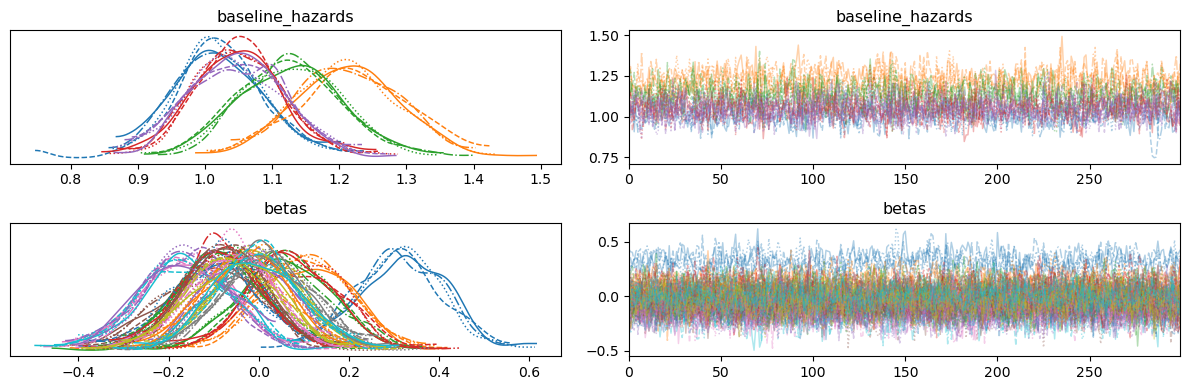

In [196]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazards", "betas"])
plt.tight_layout()
plt.show()

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

                             Mean      MCSE     StdDev        MAD  \
lp__                -14955.600000  1.002190  59.725700  59.452300   
baseline_hazards[1]      2.762580  0.001607   0.146590   0.145035   
baseline_hazards[2]      3.589360  0.002198   0.184282   0.181381   
baseline_hazards[3]      3.000430  0.001772   0.157109   0.156184   
baseline_hazards[4]      2.825690  0.001535   0.148393   0.145880   
...                           ...       ...        ...        ...   
log_lik[996]            -4.727410  0.010772   1.262980   1.215010   
log_lik[997

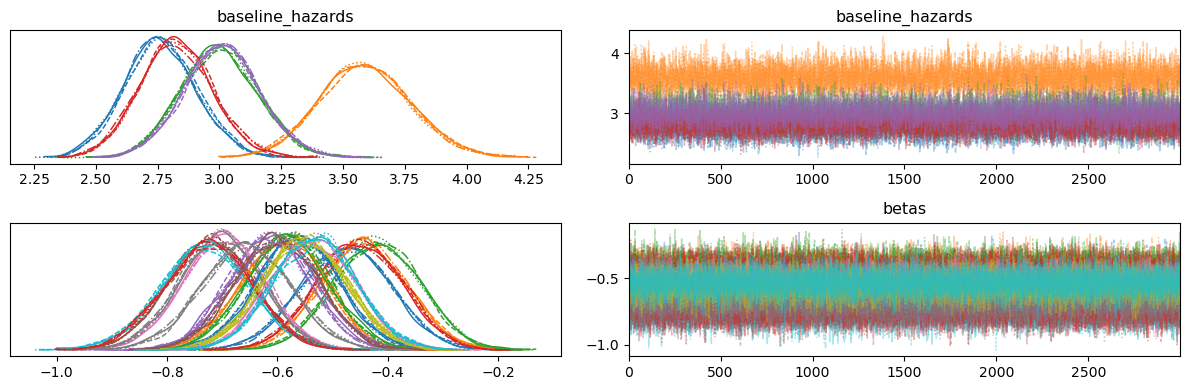

In [193]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazards", "betas"])
plt.tight_layout()
plt.show()